#### visualization of the reefscape trajectories  - 20260122 CJH

In [1]:
import matplotlib
%matplotlib inline
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import ipywidgets as widgets
from IPython.display import display, clear_output
from importlib import reload

import rebuilt_utils as ru

# --- CONSTANTS (MKS) ---
# Import constants from utils to maintain local namespace for functions
G, FIELD_X_LEN, FIELD_Y_LEN = ru.G, ru.FIELD_X_LEN, ru.FIELD_Y_LEN
HUB_CENTER_X, HUB_CENTER_Y = ru.HUB_CENTER_X, ru.HUB_CENTER_Y
HUB_TOP_H, HUB_BOT_H = ru.HUB_TOP_H, ru.HUB_BOT_H
HUB_TOP_R, HUB_BOT_R = ru.HUB_TOP_R, ru.HUB_BOT_R
R_TOP, R_BOT = ru.R_TOP, ru.R_BOT
BALL_MASS, BALL_DIAM, BALL_RADIUS, BALL_AREA = ru.BALL_MASS, ru.BALL_DIAM, ru.BALL_RADIUS, ru.BALL_AREA
AIR_DENSITY, Cd = ru.AIR_DENSITY, ru.Cd
WHEEL_CIRCUM_M, WHEEL_CIRCUM = ru.WHEEL_CIRCUM_M, ru.WHEEL_CIRCUM
HUB_DEPTH_TOTAL = ru.HUB_DEPTH_TOTAL

#### Errors
##### err_top (Top Error)
* This represents the horizontal miss distance at the height of the top rim of the Hub.
* Calculation: It is the absolute difference between the ball's horizontal position ($x$) and the center of the target when the ball's height ($y$) equals the top rim height (HUB_TOP_H).
* Purpose: It determines if the ball successfully enters the initial 41.3" opening. If err_top is greater than the available radius (R_TOP - BALL_RADIUS), the ball hits the rim or misses the goal entirely.
##### Chk (Check Error)
* This stands for Check Plane Error. It represents the horizontal miss distance at a specific depth inside the funnel (defined by BOUNCE_DEPTH_IN or w_depth).
* Calculation: It is the absolute difference between the ball's horizontal position ($x$) and the center of the target when the ball drops to the specific "Check Height" (check_h).
* Purpose: This acts as a "bounce-out" filter. A shot might clear the top rim (err_top is good) but be angled so shallowly that it hits the funnel wall immediately after entering. Chk ensures the ball is centered enough to travel deep into the funnel without hitting the sides prematurely.

#### definitions

In [2]:
def update(change=None):
    # Inputs
    rx, ry = w_rx.value, w_ry.value
    h_m = w_h.value * 0.0254
    wheel_v_surf = w_v.value
    slip = w_sl.value
    depth_m = w_depth.value * 0.0254
    
    # Geometry
    dx, dy = HUB_CENTER_X - rx, HUB_CENTER_Y - ry
    dist = np.hypot(dx, dy)
    yaw = np.degrees(np.arctan2(dy, dx))
    
    # Physics
    v_ball = wheel_v_surf * (1.0 - slip)
    rpm = (wheel_v_surf * 60) / WHEEL_CIRCUM_M
    
    lbl_info.value = f"<b>Calculated:</b> Dist: {dist:.2f} m | RPM: {int(rpm)}"
    
    # Trajectory
    xs, ys = ru.calculate_trajectory(v_ball, w_ang.value, h_m, dist, w_dr.value)
    
    # Analysis (Local for visualization)
    check_h = HUB_TOP_H - depth_m
    slope = (R_TOP - R_BOT) / HUB_DEPTH_TOTAL
    check_r = R_TOP - (slope * depth_m)
    
    # Check crossings
    cross_top_err = np.nan
    idx_top = np.where((ys[:-1] >= HUB_TOP_H) & (ys[1:] < HUB_TOP_H))[0]
    if len(idx_top) > 0:
        i = idx_top[0]
        t = (HUB_TOP_H - ys[i]) / (ys[i+1] - ys[i])
        xt = xs[i] + (xs[i+1] - xs[i]) * t
        cross_top_err = abs(xt - dist)
        
    cross_check_err = np.nan
    idx_check = np.where((ys[:-1] >= check_h) & (ys[1:] < check_h))[0]
    if len(idx_check) > 0:
        i = idx_check[0]
        t = (check_h - ys[i]) / (ys[i+1] - ys[i])
        xc = xs[i] + (xs[i+1] - xs[i]) * t
        cross_check_err = abs(xc - dist)
        
    # Status
    valid_top = cross_top_err < (R_TOP - BALL_RADIUS) if not np.isnan(cross_top_err) else False
    valid_check = cross_check_err < (check_r - BALL_RADIUS) if not np.isnan(cross_check_err) else False
    
    status = "MISS"
    color = "#F44336" # Red
    if valid_top and valid_check:
        status = "GOOD"
        color = "#4CAF50" # Green
    elif valid_top:
        status = "BOUNCED OUT"
        color = "#FF9800" # Orange
        
    # Render
    with out:
        clear_output(wait=True)
        
        # 1. Remove constrained_layout
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5)) 
        
        # 2. Add this line immediately after
        fig.subplots_adjust(wspace=0.15) # Adjust this float value (0.0 to 1.0) to tighten/loosen the gap
    
        # 1. Top View
        ax1.set_title(f"Field (Yaw: {yaw:.1f}°)")
        ax1.set_aspect('equal')
        ax1.set_xlim(-0.5, 8.5); ax1.set_ylim(-0.5, 8.5)
        ax1.add_patch(patches.Rectangle((0, 0), FIELD_X_LEN, FIELD_Y_LEN, fill=False, lw=2))
        ax1.add_patch(patches.Circle((HUB_CENTER_X, HUB_CENTER_Y), HUB_TOP_R, color='b', alpha=0.2))
        ax1.plot(HUB_CENTER_X, HUB_CENTER_Y, 'bx')
        # Robot Body: Blue Box (0.76m ~ 30 inches)
        r_dim = 0.76  
        # 1. Create the rectangle centered at (rx, ry)
        # (We subtract half the size from x and y to center it)
        rect = patches.Rectangle((rx - r_dim/2, ry - r_dim/2), r_dim, r_dim, 
                                 linewidth=2, edgecolor='b', facecolor='none')
        # 2. Apply rotation around the center point (rx, ry)
        t = matplotlib.transforms.Affine2D().rotate_deg_around(rx, ry, yaw) + ax1.transData
        rect.set_transform(t)
    
        # 3. Add to plot
        ax1.add_patch(rect)
        ax1.plot([rx, HUB_CENTER_X], [ry, HUB_CENTER_Y], 'k--', alpha=0.3)
        ax1.arrow(rx, ry, np.cos(np.radians(yaw)), np.sin(np.radians(yaw)), 
                  head_width=0.3, fc='r', ec='r')
        ax1.grid(True, alpha=0.2)
    
        # 2. Side View
        ax2.set_title(f"Trajectory | Ball v: {v_ball:.1f} m/s")
        ax2.set_xlabel(f"Dist (m) [Target @ {dist:.2f}]")
        ax2.set_ylabel("Height (m)")
        ax2.set_aspect('equal')
        ax2.plot(xs, ys, 'k-', lw=2)
        
        # ... (Polygon patch logic remains the same) ...
        xc = dist
        poly = [[xc - HUB_TOP_R, HUB_TOP_H], [xc + HUB_TOP_R, HUB_TOP_H],
                [xc + HUB_BOT_R, HUB_BOT_H], [xc - HUB_BOT_R, HUB_BOT_H]]
        ax2.add_patch(patches.Polygon(poly, closed=True, color='blue', alpha=0.2))
        ax2.hlines(HUB_TOP_H, xc - HUB_TOP_R, xc + HUB_TOP_R, colors='blue', lw=2)
        
        ax2.set_xlim(-0.5, dist + 2.0)
        ax2.set_ylim(0, max(3.5, np.max(ys) + 0.5))
        ax2.grid(True, alpha=0.3)
        ax2.axhline(0, color='k')
    
        # 3. Zoom View
        ax3.set_title(f"Status: {status}", backgroundcolor=color, color='white', weight='bold', y=0.91)
        ax3.set_xlabel(f"Err: Top {cross_top_err:.2f}m | Chk {cross_check_err:.2f}m")
        ax3.plot(xs, ys, 'k-', lw=2)
        
        # ... (Zoom view lines remain the same) ...
        ax3.plot([xc-R_TOP, xc+R_TOP], [HUB_TOP_H, HUB_TOP_H], 'b-', lw=2)
        ax3.plot([xc-R_BOT, xc+R_BOT], [HUB_BOT_H, HUB_BOT_H], 'b-', lw=1)
        ax3.plot([xc-R_TOP, xc-R_BOT], [HUB_TOP_H, HUB_BOT_H], 'b-', alpha=0.3)
        ax3.plot([xc+R_TOP, xc+R_BOT], [HUB_TOP_H, HUB_BOT_H], 'b-', alpha=0.3)
        ax3.hlines(check_h, xc-check_r, xc+check_r, colors='green', linestyles='--', label='Check Depth')
    
        ax3.set_xlim(dist - 1.0, dist + 1.0)
        ax3.set_ylim(HUB_BOT_H - 0.5, HUB_TOP_H + 1.0)
        ax3.set_aspect('equal')
        ax3.grid(True, alpha=0.5)

        plt.show()
        plt.close(fig)

#### panel sim

In [3]:
# --- WIDGETS ---
style = {'description_width': '120px'}
layout = widgets.Layout(width='95%')

# Robot
w_rx = widgets.FloatSlider(value=2.0, min=0.5, max=5, step=0.1, description='Robot X (m)', style=style, layout=layout)
w_ry = widgets.FloatSlider(value=2.0, min=0.5, max=7.5, step=0.1, description='Robot Y (m)', style=style, layout=layout)

# Shooter
w_h  = widgets.FloatSlider(value=20.0, min=10, max=30, step=0.5, description='Shoot H (in)', style=style, layout=layout)
w_ang = widgets.FloatSlider(value=70.0, min=40, max=85, step=0.5, description='Angle (deg)', style=style, layout=layout)
w_v  = widgets.FloatSlider(value=9.0, min=1, max=20, step=0.1, description='Wheel Speed (m/s)', style=style, layout=layout)
w_sl = widgets.FloatSlider(value=0.1, min=0, max=0.5, step=0.01, description='Slip (0-1)', style=style, layout=layout)
w_dr = widgets.Checkbox(value=True, description='Air Resistance')

# Criteria
w_depth = widgets.FloatSlider(value=10.0, min=0, max=22, step=1, description='Bounce Depth (in)', style=style, layout=layout)

# Info Label
lbl_info = widgets.HTML(value="<b>Calculated:</b> Dist: - | RPM: -")

out = widgets.Output()



for w in [w_rx, w_ry, w_h, w_ang, w_v, w_sl, w_dr, w_depth]:
    w.observe(update, names='value')

update()

# Define a layout that makes columns expand to fill space
col_layout = widgets.Layout(flex='1', margin='0px 10px 0px 0px')

# Apply layout to each column
col1 = widgets.VBox([widgets.HTML("<b>Robot</b>"), w_rx, w_ry], layout=col_layout)
col2 = widgets.VBox([widgets.HTML("<b>Shooter</b>"), w_h, w_ang, w_v, w_sl, w_dr], layout=col_layout)
col3 = widgets.VBox([widgets.HTML("<b>Criteria</b>"), w_depth, lbl_info], layout=col_layout)

# Set the main HBox to 100% width
ui = widgets.VBox([
    widgets.HBox([col1, col2, col3], layout=widgets.Layout(width='100%')),
    out
])
display(ui)

___
### Shooter Analysis: Vectorized Solver & Centering Quality

This simulation uses a vectorized physics engine to map the entire shooting performance space instantly.

### How it Works
1.  **Vectorized Physics:** Simulates 1,000 different velocities for every angle simultaneously to ensure no valid "bank shots" are missed.
2.  **Dual-Point Constraint:** A shot is only considered "Valid" if it clears two obstacles:
    * **The Top Rim:** Entering the 41.3" opening.
    * **The Check Plane:** Clearing the narrower funnel width at a specific depth (`BOUNCE_DEPTH_IN`). This filters out shallow shots that technically enter but hit the back wall immediately.

### The "Shot Quality" Metric
The **Valid Range by Angle** plot is color-coded based on **Centering Accuracy**:
* **<span style="color:#00CC00">Green (1.0)</span>**: **Dead Center.** The ball passes perfectly through the center axis of the funnel.
* **<span style="color:#FFCC00">Yellow (0.5)</span>**: **Off-Center.** The shot is safe but drifts toward the funnel walls.
* **<span style="color:#FF3333">Red (0.0)</span>**: **Rim Grazer.** The shot barely clears the radius limit (high risk of bouncing out).

### Visualization Notes
* **Top Plot:** Shows the RPM required for every valid configuration.
* **Bottom Plot:** Displays the valid distance range for each angle. The markers are scaled up to overlap, creating a continuous "quality gradient" bar that highlights the sweet spot.

In [9]:
# --- SAMPLE CONFIGURATION ---
SLIP = 0.25
SHOT_HEIGHT_IN = 20
MAX_RPM = 4500
BOUNCE_DEPTH_IN = 10.0

# Search Space
ANGLES = np.arange(50, 86, 1)
DISTANCES = np.arange(0.5, 6.1, 0.1)

# Depth Check Geometry
CHECK_DEPTH_M = BOUNCE_DEPTH_IN * 0.0254
CHECK_H = HUB_TOP_H - CHECK_DEPTH_M
slope = (R_TOP - R_BOT) / (HUB_TOP_H - HUB_BOT_H)
CHECK_R = R_TOP - (slope * CHECK_DEPTH_M)

EFFICIENCY = 1.0 - SLIP

# Quality Metric Constant
MAX_SAFE_R = CHECK_R - BALL_RADIUS

print(f"Config: Depth {BOUNCE_DEPTH_IN}\" ({CHECK_DEPTH_M:.2f}m) | Target Radius {CHECK_R/0.0254:.2f}\"")

Config: Depth 10.0" (0.25m) | Target Radius 17.63"


In [18]:
# --- ACTUAL CONFIGURATION ---
config = {
    'SLIP': 0.25,  # percentage of wheel velocity we lose when we send the ball off 
    'SHOT_HEIGHT_IN': 20,  # height of the shooter off the ground
    'MAX_RPM': 4500,  # limit on shooter speed
    'ANGLES': np.arange(50, 86, 0.5),  # angles to simulate
    'DISTANCES': np.arange(0.5, 6.1, 0.1),  # distances to simulate ()
    'BOUNCE_DEPTH_IN': 10.0, 
}

Config: Depth 10.0" (0.25m) | Target Radius 17.63"
Calculating 72 angles...
Angle 85.5° done.
Calculation Complete.


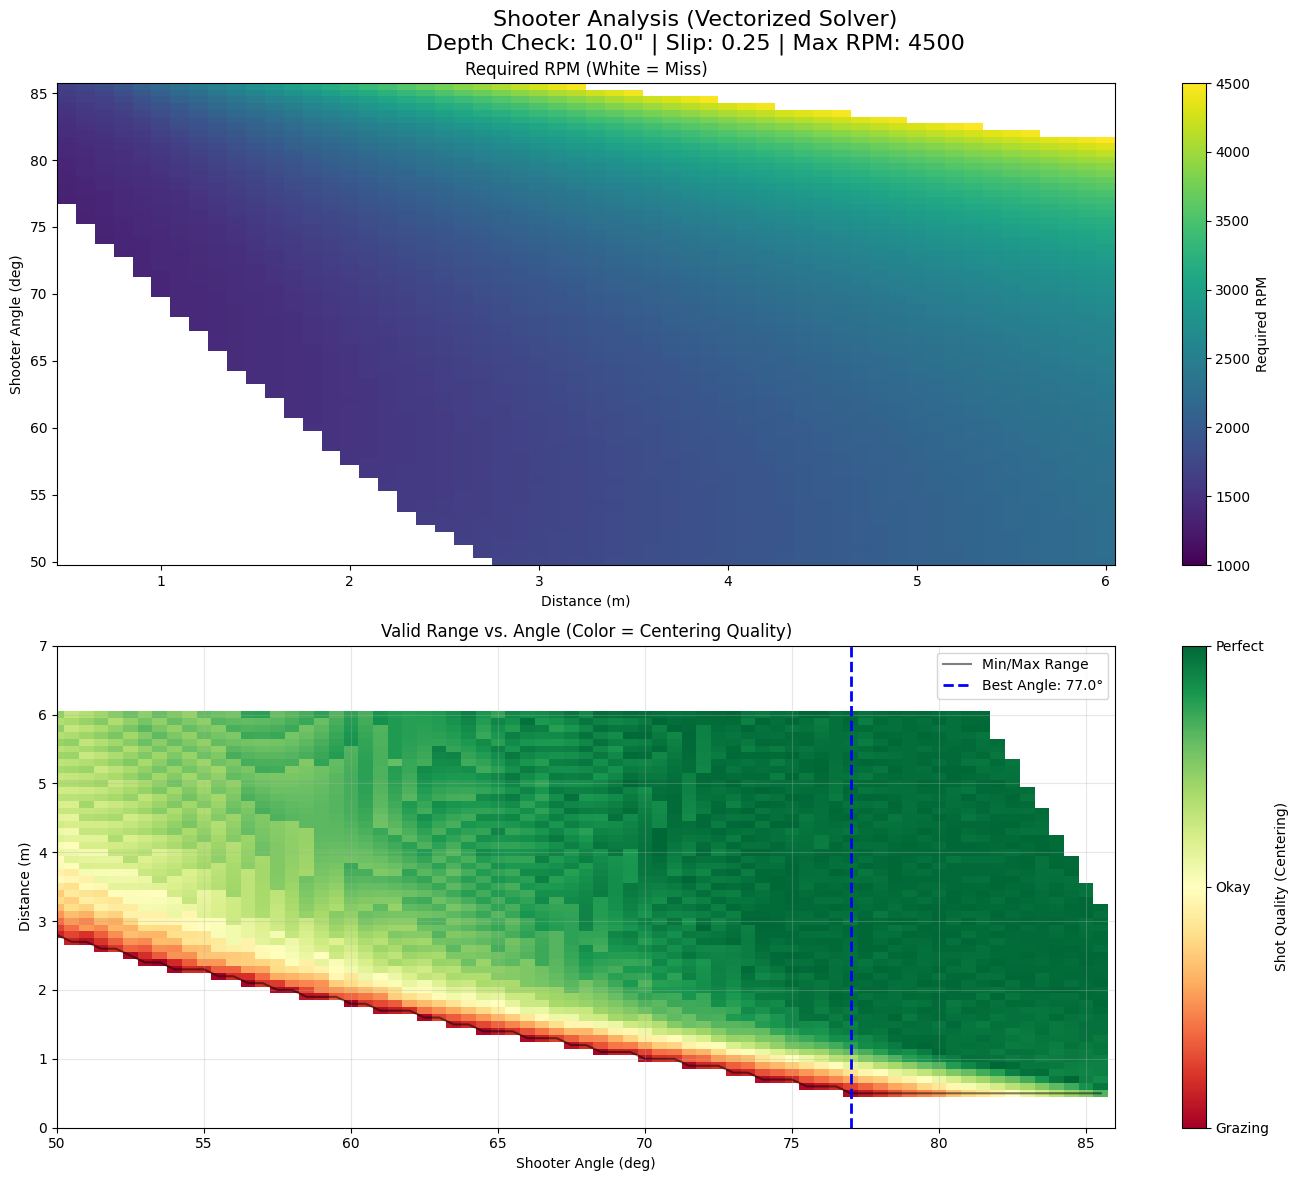

In [17]:
ru.vector_sim(config)

#### shot quality heatmap

Calculating sweep for 36 angles...
Calculation done. Plotting...


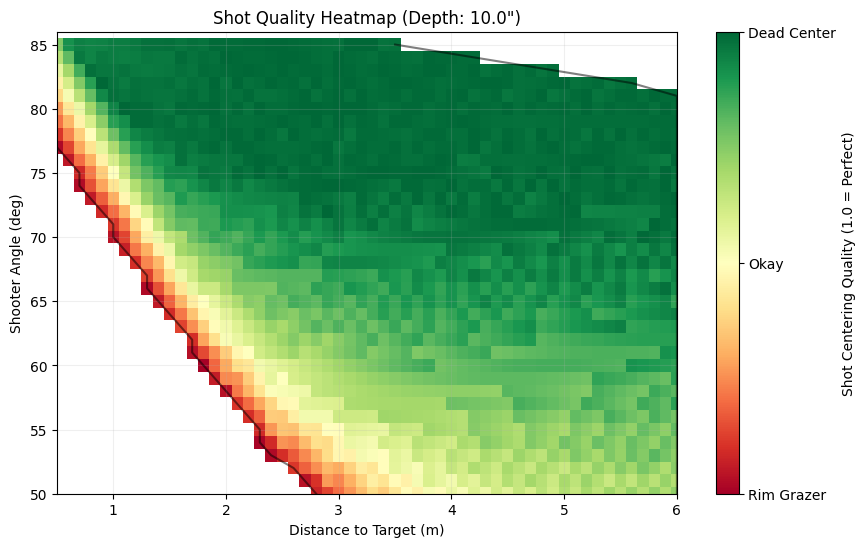

In [12]:
ru.generate_quality_heatmap(config)